# Data Subsetting and Transformation Services in the Cloud

## Using the Harmony-Py library to access customized data from NASA Earthdata 

---

## Timing:
- Exercise: 45 minutes

---

## Summary

We have already explored direct access to the NASA EOSDIS archive via the Amazon Simple Storage Service (S3) by using the Common Metadata Repository (CMR) to search for granule locations. In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection, and other transformations. 

This tutorial demonstrates how to find, request, and use customized data from a new ecosystem of services operating within the NASA Earthdata Cloud: NASA Harmony.

### Benefits

But first, why use this option when we've already learned how to access data directly from the NASA Earthdata Cloud? 

- Consistent access patterns to EOSDIS holdings make cross-data center data access easier
- Data reduction services allow users to request only the data they want, in the format and projection they want
- Analysis Ready Data and cloud access will help reduce time-to-science
- Community Development helps reduce the barriers for re-use of code and sharing of domain knowledge

![Data file filtering and subsetting](data/subsetting_diagram.png)

See more on the [Earthdata Harmony landing page](https://harmony.earthdata.nasa.gov/), including documentation on the Harmony API itself. 


### Objectives

1. Practice skills learned from the introductory CMR tutorial to discover what access and service options exist for a given data set, as well as variable metadata.
2. 
___

## Import Packages

In [1]:
from harmony import BBox, Client, Collection, Request, LinkType
from harmony.config import Environment
import requests
from pprint import pprint
import datetime as dt
import s3fs
import xarray as xr

## Discover service options for a given data set

- First, what do we mean by a "service"?
[TODO] Describe how we define services and their benefits, and how not all datasets have services on them due to level of support, etc....


- Let's see what the collection metadata tells us 

Building off of CMR introduction tutorial:

In [2]:
cmr_search_url = 'https://cmr.earthdata.nasa.gov/search'

We want to search by collection to inspect the access and service options that exist:

In [3]:
cmr_collection_url = f'{cmr_search_url}/{"collections"}'

In the CMR introduction tutorial, we explored cloud-hosted collections from different DAAC providers, and identified the CMR `concept-id` for a given data set id (also referred to as a `short_name`). 

Here we are jumping ahead and already know the `concept_id` we are interested in, by browsing cloud-hosted datasets from PO.DAAC in Earthdata Search: https://search.earthdata.nasa.gov/portal/podaac-cloud/search. 

We are going to focus on `MODIS_A-JPL-L2P-v2019.0`: GHRSST Level 2P Global Sea Surface Skin Temperature from the Moderate Resolution Imaging Spectroradiometer (MODIS) on the NASA Aqua satellite (GDS2). Let's first save this as a variable that we can use later on once we request data from Harmony.

In [4]:
short_name= 'MODIS_A-JPL-L2P-v2019.0'
concept_id = 'C1940473819-POCLOUD'

We will view the top-level metadata for this collection to see what additional service and variable metadata exist.

In [5]:
response = requests.get(cmr_collection_url, 
                        params={
                            'concept_id': concept_id,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()

Print the response:

In [6]:
pprint(response)

{'feed': {'entry': [{'archive_center': 'NASA/JPL/PODAAC',
                     'associations': {'services': ['S1962070864-POCLOUD',
                                                   'S2004184019-POCLOUD'],
                                      'tools': ['TL2108419875-POCLOUD',
                                                'TL2092786348-POCLOUD'],
                                      'variables': ['V1997812737-POCLOUD',
                                                    'V1997812697-POCLOUD',
                                                    'V2112014688-POCLOUD',
                                                    'V1997812756-POCLOUD',
                                                    'V1997812688-POCLOUD',
                                                    'V1997812670-POCLOUD',
                                                    'V1997812724-POCLOUD',
                                                    'V2112014684-POCLOUD',
                                                

Let's walk through what each of these service values mean:

- Associations
     - CMR is a large web of interconnected metadata "schemas", including Collections, Granules, Services, Tools, and Variables. In this case, this collection is associated with two unique services, two tools, and several unique variables.
- Tags
    - There are also tags that describe what service options exist at a high-level. In this case, we see that this dataset supports the ability to reformat, subset by space and time, as well as by variable. This is used in web applications like Earthdata Search to surface those customization options more readily. 
- Service Features
    - In this case, we see three separate "features" listed here: esi, Harmony, and OPeNDAP.
    
We will dig into more details on what Harmony offers for this dataset.

First, we need to isolate the services returned for this dataset:

In [7]:
services = response['feed']['entry'][0]['associations']['services']
print(services)

['S1962070864-POCLOUD', 'S2004184019-POCLOUD']


In [8]:
cmr_service_url = "https://cmr.earthdata.nasa.gov/search/services"

Inspect the first service returned. Now we're going to search the services endpoint to view that individual service's metadata, like we did with our dataset above.

TODO: Explain why we need the output format in umm_json

In [9]:
output_format = "umm_json"

In [10]:
service_response = requests.get(f"{cmr_service_url}.{output_format}?concept-id={services[0]}")

In [11]:
pprint(service_response.json())

{'hits': 1,
 'items': [{'meta': {'concept-id': 'S1962070864-POCLOUD',
                     'concept-type': 'service',
                     'deleted': False,
                     'format': 'application/vnd.nasa.cmr.umm+json',
                     'native-id': 'POCLOUD_podaac_l2_cloud_subsetter',
                     'provider-id': 'POCLOUD',
                     'revision-date': '2021-11-02T22:57:03.597Z',
                     'revision-id': 19,
                     'user-id': 'podaaccloud'},
            'umm': {'AccessConstraints': 'None',
                    'Description': 'Endpoint for subsetting L2 Subsetter via '
                                   'Harmony',
                    'LongName': 'PODAAC Level 2 Cloud Subsetter',
                    'MetadataSpecification': {'Name': 'UMM-S',
                                              'URL': 'https://cdn.earthdata.nasa.gov/umm/service/v1.4',
                                              'Version': '1.4'},
                    'Name': 'PO

TODO: Describe these different service options and broader Harmony / backend subsetter context.

## Discover variable names

TODO: Could this be an "exercise" to gain more familiarity with CMR? 

In [12]:
variables = response['feed']['entry'][0]['associations']['variables']
print(variables)

['V1997812737-POCLOUD', 'V1997812697-POCLOUD', 'V2112014688-POCLOUD', 'V1997812756-POCLOUD', 'V1997812688-POCLOUD', 'V1997812670-POCLOUD', 'V1997812724-POCLOUD', 'V2112014684-POCLOUD', 'V1997812701-POCLOUD', 'V1997812681-POCLOUD', 'V2112014686-POCLOUD', 'V1997812663-POCLOUD', 'V1997812676-POCLOUD', 'V1997812744-POCLOUD', 'V1997812714-POCLOUD']


In [13]:
cmr_var_url = "https://cmr.earthdata.nasa.gov/search/variables"

In [14]:
var_response = requests.get(f"{cmr_var_url}.{output_format}?concept-id={variables[0]}")

In [15]:
pprint(var_response.json())

{'hits': 1,
 'items': [{'associations': {'collections': [{'concept-id': 'C1940473819-POCLOUD'}]},
            'meta': {'concept-id': 'V1997812737-POCLOUD',
                     'concept-type': 'variable',
                     'deleted': False,
                     'format': 'application/vnd.nasa.cmr.umm+json',
                     'native-id': 'MODIS_A-JPL-L2P-v2019.0-sses_standard_deviation_4um',
                     'provider-id': 'POCLOUD',
                     'revision-date': '2021-10-19T02:26:51.560Z',
                     'revision-id': 6,
                     'user-id': 'jmcnelis'},
            'umm': {'DataType': 'byte',
                    'Definition': 'mid-IR SST standard deviation error; non '
                                  'L2P core field; signed byte array:  WARNING '
                                  'Some applications are unable to properly '
                                  'handle signed byte values. If values are '
                                  'encountered 

Let's print out a simple list of all associated variable names.

In [16]:
var_list = []
for i in range(len(variables)):
    response = requests.get(f"{cmr_var_url}.{output_format}?concept-id={variables[i]}")
    response = response.json()
    var_list.append(response['items'][0]['umm']['Name'])

In [17]:
pprint(var_list)

['sses_standard_deviation_4um',
 'l2p_flags',
 'time',
 'dt_analysis',
 'sses_standard_deviation',
 'sst_dtime',
 'sses_bias_4um',
 'lat',
 'sea_surface_temperature_4um',
 'sses_bias',
 'lon',
 'sea_surface_temperature',
 'quality_level',
 'wind_speed',
 'quality_level_4um']


## Find all collections that have harmony type??

## Harmony-Py set up

[TODO] Describe Harmony-Py in more detail (connection between the library and the API).

Harmony-Py is a Python library for integrating with NASA's Harmony Services.

Harmony-Py provides a Python alternative to directly using Harmony's RESTful API. It handles NASA Earthdata Login (EDL) authentication and optionally integrates with the CMR Python Wrapper by accepting collection results as a request parameter. It's convenient for scientists who wish to use Harmony from Jupyter notebooks as well as machine-to-machine communication with larger Python applications.

Next steps adopted from the intro tutorial notebook in the Harmony-Py library: https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb

### Create Harmony Client object
First, we need to create a Harmony Client, which is what we will interact with to submit and inspect a data request to Harmony, as well as to retrieve results.

When creating the Client, we need to provide Earthdata Login credentials, which are required to access data from NASA EOSDIS. This basic line below assumes that we have a `.netrc` available. 

In [18]:
harmony_client = Client()

### Create Harmony Request
The following are common request parameters:

- `collection`: Required parameter. This is the NASA EOSDIS collection, or data product. There are two options for inputting a collection of interest:
    - Provide a concept ID, which is an ID provided in the Common Metadata Repository (CMR) metadata
    - Data product short name (e.g. SENTINEL-1_INTERFEROGRAMS).
- `spatial`: Bounding box spatial constraints on the data. The Harmony Bbox class accepts spatial coordinates as decimal degrees in w, s, e, n order, where longitude = -180, 180 and latitude = -90, 90.
- `temporal`: Date/time constraints on the data. The example below demonstrates temporal start and end ranges using the python datetime library.

Other advanced parameters that may be of interest. Note that many reformatting or advanced projection options may not be available for your requested dataset. See the [documentation](https://harmony-py.readthedocs.io/en/latest/) for details on how to construct these parameters.

[TODO] Describe area/time use case with this dataset - maybe demonstrating Earthdata Search for browsing??

We will search over the Gulf of Mexico during the period 1 Aug 2020 to 1 Nov 2020, since we are interested in exploring how SST responds during the latest Atlantic hurricane season.

In [24]:
request = Request(
    collection=Collection(id=short_name),
#    spatial=BBox(60,-45.75,90,-45), # bounding box example that can be used as an alternative to shapefile input
    spatial=BBox(-97.77667,21.20806,-83.05197,30.16605), # bounding box example that can be used as an alternative to shapefile input
    temporal={
        # 'start': dt.datetime(2021, 11, 1),
        # 'stop': dt.datetime(2021, 11, 2),
        'start': dt.datetime(2021, 8, 1),
        'stop': dt.datetime(2021, 8, 2),
    },
    # variables=variables,
)

### Check Request validity
Before submitting a Harmony Request, we can test your request to see if it's valid and how to fix it if not. In particular, `request.is_valid` will check to ensure that the spatial BBox bounds and temporal ranges are entered correctly.

In [25]:
request.is_valid()

True

### Submit request

Now that the request is created, we can now submit it to Harmony using the Harmony Client object. A job id is returned, which is a unique identifier that represents the submitted request.

In [26]:
job_id = harmony_client.submit(request)
job_id

'9979fa59-f3e9-4ac9-b8c1-2888bc736258'

### Check request status

We can check on the progress of a processing job with status(). This method blocks while communicating with the server but returns quickly.

In [27]:
harmony_client.status(job_id)

{'status': 'running',
 'message': 'There were 2 collections that matched the provided short name MODIS_A-JPL-L2P-v2019.0. See https://cmr.earthdata.nasa.gov/concepts/C1940473819-POCLOUD for details on the selected collection. The version ID for the selected collection is 2019.0. To use a different collection submit a new request specifying the desired CMR concept ID instead of the collection short name.',
 'progress': 0,
 'created_at': datetime.datetime(2021, 11, 11, 4, 23, 47, 746000, tzinfo=tzlocal()),
 'updated_at': datetime.datetime(2021, 11, 11, 4, 23, 47, 746000, tzinfo=tzlocal()),
 'request': 'https://harmony.earthdata.nasa.gov/MODIS_A-JPL-L2P-v2019.0/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat(21.20806%3A30.16605)&subset=lon(-97.77667%3A-83.05197)&subset=time(%222021-08-01T00%3A00%3A00%22%3A%222021-08-02T00%3A00%3A00%22)',
 'num_input_granules': 6}

Depending on the size of the request, it may be helpful to wait until the request has completed processing before the remainder of the code is executed. The wait_for_processing() method will block subsequent lines of code while optionally showing a progress bar.

In [28]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


### View Harmony job response and output URLs
Once the data request has finished processing, we can view details on the job that was submitted to Harmony, including the API call to Harmony, and informational messages on the request if available.

result_json() calls wait_for_processing() and returns the complete job in JSON format once processing is complete. 

In [33]:
data = harmony_client.result_json(job_id)
pprint(data)

{'createdAt': '2021-11-11T04:23:47.746Z',
 'jobID': '9979fa59-f3e9-4ac9-b8c1-2888bc736258',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/stac/9979fa59-f3e9-4ac9-b8c1-2888bc736258/',
            'rel': 'stac-catalog-json',
            'title': 'STAC catalog',
            'type': 'application/json'},
           {'bbox': [-95.851, 29.339, -62.863, 50.743],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/b081caea-4c8c-4118-b613-e8688b16140c/20210801072501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4',
            'rel': 'data',
            'temporal': {'end': '2021-08-01T07:29:58.000Z',
                         'start': '2021-08-01T07:25:01.000Z'},
            'title': '20210801072501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4',
            'type': 'application/x-netcdf4'},
           {'bbox': [-97.5, 21.2, -83.1, 30.2],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harm

### Direct cloud access

Note that the remainder of this tutorial will only succeed when running this notebook within the AWS us-west-2 region.

Harmony data outputs can be accessed within the cloud using the s3 URLs and AWS credentials provided in the Harmony job response.

#### Retrieve list of output URLs.

The result_urls() method calls wait_for_processing() and returns a list of the processed data URLs once processing is complete. You may optionally show the progress bar as shown below.

In [34]:
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
urls = list(results)
pprint(urls)

['s3://harmony-prod-staging/public/podaac/l2-subsetter/b081caea-4c8c-4118-b613-e8688b16140c/20210801072501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/b081caea-4c8c-4118-b613-e8688b16140c/20210801073001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/b081caea-4c8c-4118-b613-e8688b16140c/20210801090501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/b081caea-4c8c-4118-b613-e8688b16140c/20210801182501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/b081caea-4c8c-4118-b613-e8688b16140c/20210801183001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/b081caea-4c8c-4118-b613-e8688b16140c/20210801200501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc

We can see that the first file returned does not include the `_subsetted` suffix, which indicates that a blank file was returned, as no data values were located within our subsetted region. We'll select the second URL in the list to bring into xarray below.

In [35]:
url = urls[1]
url

's3://harmony-prod-staging/public/podaac/l2-subsetter/b081caea-4c8c-4118-b613-e8688b16140c/20210801073001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4'

#### AWS credential retrieval
Using aws_credentials you can retrieve the credentials needed to access the Harmony s3 staging bucket and its contents.

In [36]:
creds = harmony_client.aws_credentials()

### Open staged files with *s3fs* and *xarray*

We use the AWS `s3fs` package to create a file system that can then be read by xarray:

In [39]:
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

### **Note, Ideally, we'd show how to bring in all files into a single xarray ds but I'm getting an error:

In [44]:
# # Iterate through remote_files to create a fileset
# fileset = [s3_fs.open(file) for file in urls]
# fileset
# ds = xr.open_mfdataset(fileset)

Now that we have our s3 file system set, including our declared credentials, we'll use that to open the url, and read in the file through xarray:

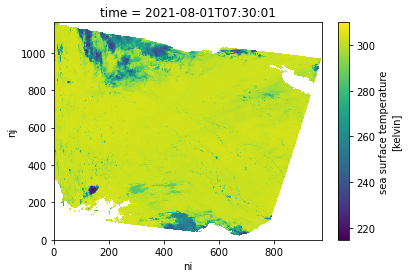

In [40]:
f = s3_fs.open(url, mode='rb')
# ds = xr.open_dataset(f, decode_cf=False)
ds = xr.open_dataset(f)
ds.sea_surface_temperature.plot()
f.close()

### Plot the data

In [ ]:
# # Determine the lat/lon coordinate names
# for coord_name, coord in ds.coords.items():
#     if 'units' not in coord.attrs:
#         continue
#     if coord.attrs['units'] == 'degrees_north':
#         lat_var = coord_name
#     if coord.attrs['units'] == 'degrees_east':
#         lon_var = coord_name

# print(f'lat_var={lat_var}')
# print(f'lon_var={lon_var}')

# # if ds[variable].size == 0:
# #     print("No data in subsetted region. Exiting")
# #     sys.exit(0)
    
# import matplotlib.pyplot as plt
# import math

# fig, axes = plt.subplots(ncols=3, nrows=math.ceil((len(ds.data_vars)/3)))
# fig.set_size_inches((15,15))

# for count, xvar in enumerate(ds.data_vars):
#     if  ds[xvar].dtype == "timedelta64[ns]":
#         continue
#         #ds[xvar].astype('timedelta64[D]').plot(ax=axes[int(count/3)][count%3])
#     ds[xvar].plot(ax=axes[int(count/3)][count%3])

### Extra code attempting to read in directly from s3 into xarray:

In [ ]:
# netcdf_stores = [netcdf_fs.get_mapper(root=u, check=False) for u in urls]
# netcdf_stores

# xr.open_mfdataset(netcdf_stores)

## Resources

https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Colocate_satellite_insitu_ocean.ipynb

